In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import matplotlib.pyplot as plt
from itertools import product
import os
import numpy as np
from torch.utils.data import DataLoader, Dataset,random_split, ConcatDataset
from torchvision import datasets, transforms
from sklearn.metrics import f1_score

import netCDF4 as nc
from scipy.ndimage import zoom

npyPath = "skogsstyrelsen-data"
ncPath = "skogsstyrelsen-data/2A-netcdfs-cropped-from-nuria"
npyFiles =["skogs_json_test.npy", "skogs_json_train.npy", "skogs_json_val.npy"]


In [56]:
def npy_loader():
    
    
    # Initialize data_list outside the loop
    data_list = []

    # Load and print contents of each file
    for file_name in npyFiles:
        full_path = os.path.join(npyPath, file_name)  # Include folder path
        if os.path.exists(full_path):  # Ensure file exists
            data = np.load(full_path, allow_pickle=True)  # Load the .npy file
            # Extract 'ValideringsobjektBildId' and 'MolnDis' from each JSON line
            if isinstance(data, np.ndarray) and data.size > 0 and isinstance(data[0], dict):
                for item in data:
                    valideringsobjekt_bild_id = item.get('ValideringsobjektBildId', 'N/A')
                    moln_dis = item.get('MolnDis', 'N/A')
                    # Add to a list of lists
                    data_list.append([valideringsobjekt_bild_id, moln_dis])
            else:
                print(f"File {file_name} does not contain the expected JSON data.")
        else:
            print(f"File {file_name} does not exist.")
    print(f"Loaded {len(data_list)} items.")
    return data_list


In [57]:

def combine_bands(data_list):
    bands = ['b02','b03', 'b04']
    target_shape = (22, 22)  # Ensure uniform size

    features = []
    labels = []

    for item in data_list:
        file_id, label = item
        file_path = os.path.join(ncPath, f'skgs_{file_id}.nc')

        try:
            with nc.Dataset(file_path, 'r') as dataset:
                resampled_bands = []

                for band in bands:
                    if band in dataset.variables:
                        band_data = dataset.variables[band][0, :, :]  # Extract first time slice
                        band_data = np.nan_to_num(band_data, nan=0.0)  # Replace NaNs with 0

                        # We use edge padding
                        #
                        if band_data.shape != target_shape:
                            print(f"Padding {file_id}: {band_data.shape} → {target_shape}")
                            pad_width = get_padding(band_data.shape, target_shape)
                            #
                            band_data = np.pad(band_data, pad_width, mode='edge')
                        

                        resampled_bands.append(band_data)
                    else:
                        print(f"Warning: {band} not found in {file_path}")
                        resampled_bands.append(np.zeros(target_shape))  # Default empty band

                # Ensure we always have (4, 21, 21)
                combined_bands = np.stack(resampled_bands, axis=0)  # (C, H, W)
                print(f"Final processed shape: {combined_bands.shape}")  # Debugging

                features.append(combined_bands)
                labels.append(label)

        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    print(f"Processed {len(features)} samples.")

    return np.array(features, dtype=np.float32), np.array(labels, dtype=np.int64)

# Compute the padding required for each dimension
def get_padding(band_shape, target_shape):
    return [(0, max(0, target_shape[i] - band_shape[i])) for i in range(len(target_shape))]



In [58]:
def calculate_mean_std(train_dataset):
    
    mean_values = []
    std_values = []
    
    train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
    
    for imgs, _ in train_loader:
        num_channels = imgs.shape[1]
        for channel in range(num_channels):
            num_pixels_per_channel = imgs.shape[0] * imgs.shape[2] * imgs.shape[3] # number of images * image height * image width
            mean = imgs[:,channel,:,:].sum() / num_pixels_per_channel
            std = torch.sqrt((((imgs[:,channel,:,:] - mean) ** 2).sum()) / num_pixels_per_channel)
            print("channel: ", channel, "mean: ", mean.item(), "std: ", std.item())
            mean_values.append(mean.item())
            std_values.append(std.item())

    return mean_values, std_values

Loaded 432 items.
Padding 765861ec-42c7-ed11-9174-005056a6f472: (21, 21) → (22, 22)
Padding 765861ec-42c7-ed11-9174-005056a6f472: (21, 21) → (22, 22)
Padding 765861ec-42c7-ed11-9174-005056a6f472: (21, 21) → (22, 22)
Final processed shape: (3, 22, 22)
Padding 1657a784-3ac7-ed11-9174-005056a6f472: (21, 21) → (22, 22)
Padding 1657a784-3ac7-ed11-9174-005056a6f472: (21, 21) → (22, 22)
Padding 1657a784-3ac7-ed11-9174-005056a6f472: (21, 21) → (22, 22)
Final processed shape: (3, 22, 22)
Padding ee53636e-47c7-ed11-9174-005056a6f472: (20, 20) → (22, 22)
Padding ee53636e-47c7-ed11-9174-005056a6f472: (20, 20) → (22, 22)
Padding ee53636e-47c7-ed11-9174-005056a6f472: (20, 20) → (22, 22)
Final processed shape: (3, 22, 22)
Padding 6a61b1e6-45c7-ed11-9174-005056a6f472: (21, 20) → (22, 22)
Padding 6a61b1e6-45c7-ed11-9174-005056a6f472: (21, 20) → (22, 22)
Padding 6a61b1e6-45c7-ed11-9174-005056a6f472: (21, 20) → (22, 22)
Final processed shape: (3, 22, 22)
Padding 50b88b11-3ec7-ed11-9174-005056a6f472: (21,

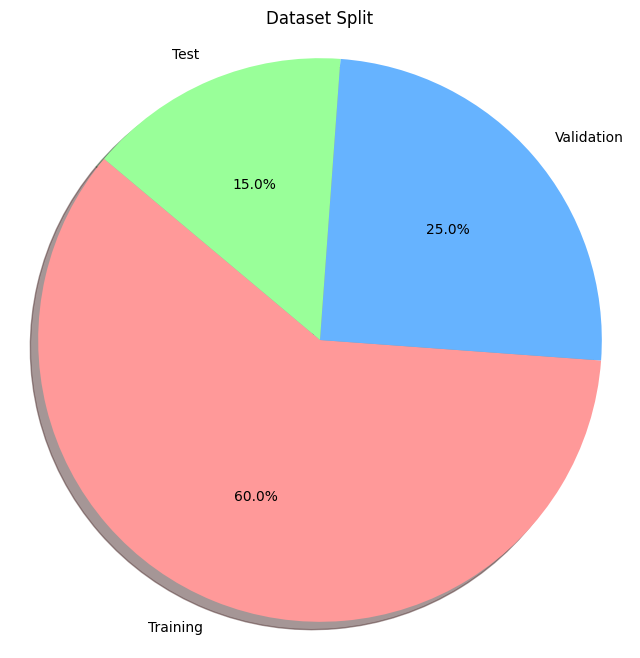

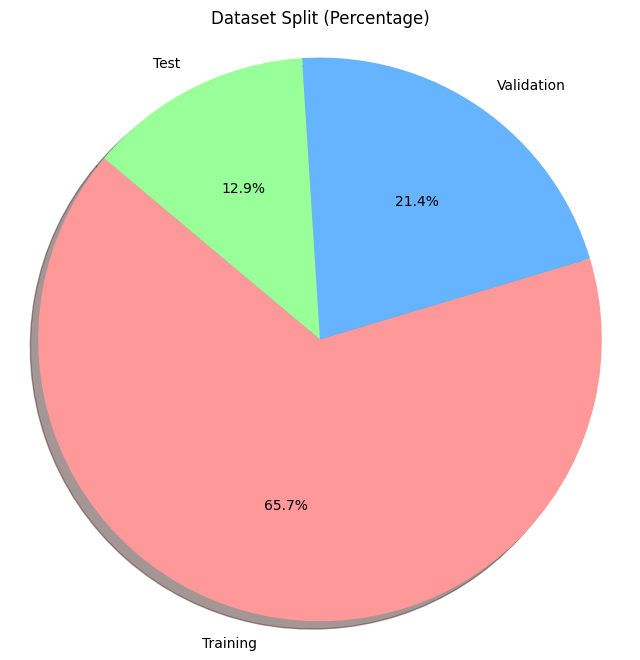

In [59]:

class SatelliteDataset(Dataset):
    def __init__(self, features, labels, transform=None):
        """
        Args:
            features (numpy array or torch.Tensor): Multi-band satellite images (shape: N x C x H x W).
            labels (numpy array or torch.Tensor): Binary labels (0 or 1).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.features = torch.tensor(features, dtype=torch.float32)  # Convert to tensor
        self.labels = torch.tensor(labels, dtype=torch.long)  # Convert to tensor
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.features[idx]  # Get image (shape: C x H x W)
        label = self.labels[idx]    # Get corresponding label

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, label

features, labels = combine_bands(npy_loader(),)

print(features.shape, labels.shape)


#dataset_transform = SatelliteDataset(features, labels, transform=transform)
dataset = SatelliteDataset(features, labels)



# Random split of the data
validation_split = 0.25
train_split = 0.6
test_split = 0.15

# Define the sizes for each split
train_size = int(train_split * len(dataset))
val_size = int(validation_split * len(dataset))
test_size = len(dataset) - train_size - val_size


# Set random seed for reproducibility
generator = torch.Generator().manual_seed(31)

# Split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

# Calculate the mean and std of the training set -> used to normalize train, val and testset
mean, std = calculate_mean_std(train_dataset)

# Get all cloud images from the training set
# Get all cloud images (label 1) from the training set
cloudy_indices = [i for i, (_, label) in enumerate(train_dataset) if label == 1]
cloudy_dataset = torch.utils.data.Subset(train_dataset, cloudy_indices)

# Clouddataset
transformCloud = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flipping
    transforms.RandomRotation([0, 90]),  # Random rotation up to 40 degrees
    transforms.Normalize(mean=mean, std=std)  # Normalize using calculated mean and std
])

# Define the transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flipping
    transforms.RandomRotation([90, 270]),  # Random rotation up to 40 degrees
    transforms.Normalize(mean=mean, std=std)  # Normalize using calculated mean and std
])

transform_normalize = transforms.Compose([
    transforms.Normalize(mean=mean, std=std)  # Normalize values to [0, 1]
])

cloudy_dataset.dataset.transform = transformCloud
train_dataset.dataset.transform = transform
val_dataset.dataset.transform = transform_normalize
test_dataset.dataset.transform = transform_normalize

# Combine the datasets
train_dataset = ConcatDataset([train_dataset, cloudy_dataset])


# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Function to plot images from datasets




print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))
print("Number of testing samples:", len(test_dataset))







sizes = [train_size, val_size, test_size]
labels = ['Training', 'Validation', 'Test']
colors = ['#ff9999','#66b3ff','#99ff99']

plt.figure(figsize=(8, 8))
plt.pie(sizes,labels=labels, colors=colors, autopct='%1.1f%%',
    shadow=True, startangle=140)
plt.title('Dataset Split')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Pie chart of dataset splits
total_size = len(dataset)
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)

train_percent = (train_size / total_size) * 100
val_percent = (val_size / total_size) * 100
test_percent = (test_size / total_size) * 100

# Pie chart of dataset splits using percentages
sizes = [train_percent, val_percent, test_percent]
labels = ['Training', 'Validation', 'Test']
colors = ['#ff9999','#66b3ff','#99ff99']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
    shadow=True, startangle=140)
plt.title('Dataset Split (Percentage)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [60]:
import matplotlib.pyplot as plt
from sklearn import metrics
import torch


def confusion_matrix(all_labels,all_predictions, class_labels=[0, 1]):
    
    # Compute the confusion matrix
    cm = metrics.confusion_matrix(all_labels, all_predictions)

    # Set up the figure with a proper aspect ratio
    fig, ax = plt.subplots(figsize=(6, 6))  # Adjust figure size
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    cm_display.plot(cmap='Blues', values_format='d', ax=ax)

    # Adjust layout for a cleaner look
    plt.tight_layout()
    plt.show()


In [61]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            

            nn.Flatten(),

            nn.Linear(in_features=64*5*5, out_features=128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(in_features=64, out_features=2),
        )

    def forward(self, x): 
        return self.layer(x)
    


In [62]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [63]:
from sklearn.utils.class_weight import compute_class_weight

targets = []  # Collect all labels from train_loader
for _, labels in train_loader:
    targets.extend(labels.numpy())  # Assuming labels are tensors, convert them to numpy

class_weights = compute_class_weight("balanced", classes=np.unique(targets), y=targets)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

In [70]:
model = Net().to(device)
#model = CloudDetectionCNN().to(device)

# Define loss function and optimizer
#criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
train_loss = []
val_loss_array = []
# Training loop
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss.append(running_loss/len(train_loader))
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        model.eval()
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
        # Save the best model
        
        # Save the best model based on validation accuracy
        if epoch == 0 or (100 * val_correct / val_total) > best_accuracy:
            best_accuracy = 100 * val_correct / val_total
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, 'cloudclass.pth')
    val_loss_array.append(val_loss/len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {running_loss/len(train_loader):.2f} | Train Accuracy: {100 * train_correct / train_total:.2f}% | Validation Loss: {val_loss/len(val_loader):.2f} | Val Accuracy: {100 * val_correct / val_total:.2f}%")
print(f"Best validation accuracy: {best_accuracy:.2f}%")

Epoch 1/300 | Train Loss: 0.67 | Train Accuracy: 59.64% | Validation Loss: 0.65 | Val Accuracy: 77.78%
Epoch 2/300 | Train Loss: 0.63 | Train Accuracy: 70.18% | Validation Loss: 0.60 | Val Accuracy: 76.85%
Epoch 3/300 | Train Loss: 0.58 | Train Accuracy: 72.59% | Validation Loss: 0.53 | Val Accuracy: 80.56%
Epoch 4/300 | Train Loss: 0.53 | Train Accuracy: 78.01% | Validation Loss: 0.45 | Val Accuracy: 86.11%
Epoch 5/300 | Train Loss: 0.45 | Train Accuracy: 80.12% | Validation Loss: 0.39 | Val Accuracy: 87.04%
Epoch 6/300 | Train Loss: 0.43 | Train Accuracy: 82.23% | Validation Loss: 0.38 | Val Accuracy: 85.19%
Epoch 7/300 | Train Loss: 0.39 | Train Accuracy: 84.34% | Validation Loss: 0.33 | Val Accuracy: 87.04%
Epoch 8/300 | Train Loss: 0.38 | Train Accuracy: 84.64% | Validation Loss: 0.30 | Val Accuracy: 87.04%
Epoch 9/300 | Train Loss: 0.35 | Train Accuracy: 84.64% | Validation Loss: 0.32 | Val Accuracy: 86.11%
Epoch 10/300 | Train Loss: 0.34 | Train Accuracy: 86.14% | Validation Los

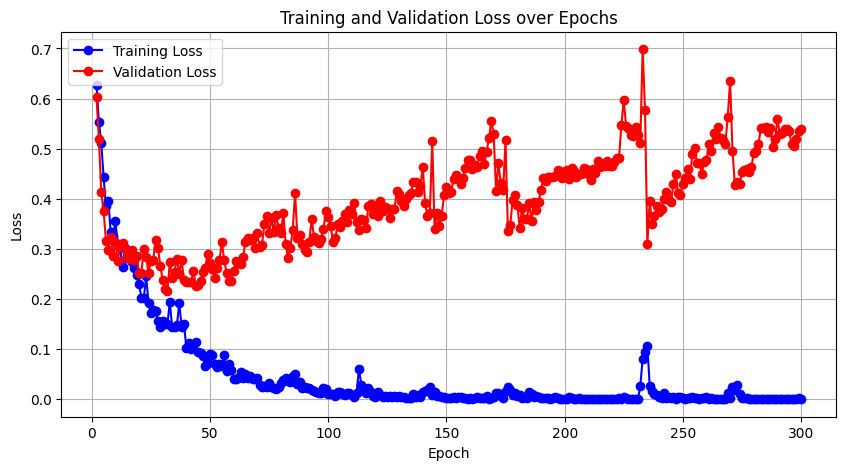

In [65]:
# Plot training and validation loss, skipping the first epoch
plt.figure(figsize=(10, 5))
plt.plot(range(2, num_epochs + 1), train_loss[1:], marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(range(2, num_epochs + 1), val_loss_array[1:], marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\anton\AppData\Local\Temp\ipykernel_34420\2216038665.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('cloudclass.pth'))


Test Loss: 0.6719315449396746, Accuracy: 86.15384615384616%, F1 Score: 76.92307692307693%


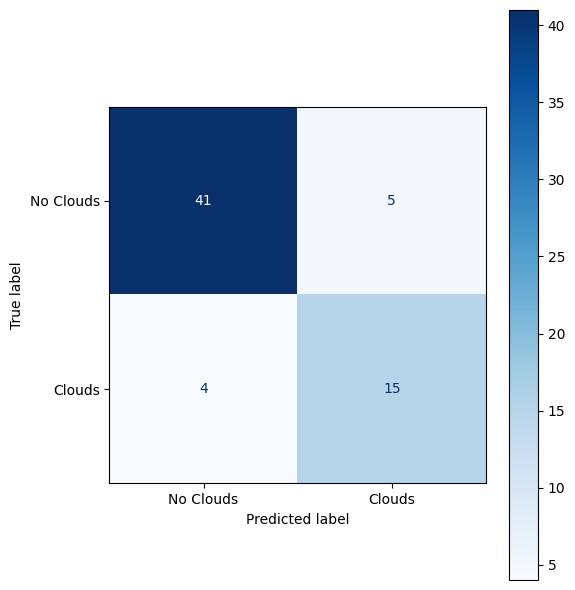

In [73]:
# Test the model
model.eval()
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_preds = []
with torch.no_grad():
    # Load the best model weights
    model.load_state_dict(torch.load('cloudclass.pth'))
    
    for inputs, labels in test_loader:
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Collect labels and predictions for f1 score
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Compute the f1 score
f1 = f1_score(all_labels, all_preds)
print(f"Test Loss: {test_loss/len(test_loader)}, Accuracy: {100 * correct / total}%, F1 Score: {f1*100}%")


confusion_matrix(all_labels,all_preds, class_labels=['No Clouds', 'Clouds'])


# ANN-Model


In [67]:
class ANNClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ANNClassifier, self).__init__()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)  # Batch Normalization
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.drop1 = nn.Dropout(0.2) # Dropout for regularization

        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.relu3 = nn.LeakyReLU(negative_slope=0.01)
        self.drop2 = nn.Dropout(0.2)

        self.fc4 = nn.Linear(64, num_classes) 

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.drop1(self.relu2(self.bn2(self.fc2(x))))
        x = self.drop2(self.relu3(self.bn3(self.fc3(x))))
        x = self.fc4(x)
        return x


def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    
    train_loss_array = []
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_train_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1) 
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_train_loss += loss.item()

        train_acc = 100 * correct / total
        training_loss = running_train_loss/len(train_loader)
        train_loss_array.append(training_loss)

        # Validation
        val_loss, val_acc, _, _ = test_model(val_loader, model)

        # Save the best model based on validation accuracy
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, 'cloudclass.pth')


        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {training_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
    print(f"Best validation accuracy: {best_accuracy}%")
    
    return model


def test_model(loader, model = None):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        # Load the best model weights
        if model == None:
            model.load_state_dict(torch.load('cloudclass.pth'))

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)

            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
            
            all_labels.extend(labels)
            all_preds.extend(predicted)
        
        loss = running_loss/len(loader)
        accuracy = 100 * correct / total
            
    return loss, accuracy, np.array(all_labels), np.array(all_preds)


def plot_confusion_matrix(all_labels = None, all_predictions = None, class_labels = [0, 1]):
    
    if all_labels is None or all_predictions is None:
        print("Error: all_labels or all_predictions needs to be passed")
    
    # Compute the confusion matrix
    cm = metrics.confusion_matrix(all_labels, all_predictions)

    print(cm)

    # Set up the figure with a proper aspect ratio
    fig, ax = plt.subplots(figsize=(6, 6))  # Adjust figure size
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    cm_display.plot(cmap='Blues', values_format='d', ax=ax)

    # Adjust layout for a cleaner look
    plt.tight_layout()
    plt.show()

In [68]:
# Labels aus dem Trainingsset extrahieren
train_labels = [label for _, label in train_dataset]

# Anzahl der Samples pro Klasse berechnen
class_counts = np.bincount(train_labels)
total_samples = len(train_labels)

# Gewichte berechnen (inverse Häufigkeit)
class_weights = total_samples / (len(class_counts) * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

Epoch 1/200, Train Loss: 0.5352, Val Loss: 0.3619, Train Acc: 73.49%, Val Acc: 75.38%
Epoch 2/200, Train Loss: 0.4080, Val Loss: 0.2730, Train Acc: 83.73%, Val Acc: 75.38%
Epoch 3/200, Train Loss: 0.3349, Val Loss: 0.2323, Train Acc: 86.75%, Val Acc: 80.00%
Epoch 4/200, Train Loss: 0.3093, Val Loss: 0.2133, Train Acc: 89.16%, Val Acc: 78.46%
Epoch 5/200, Train Loss: 0.2688, Val Loss: 0.2410, Train Acc: 91.27%, Val Acc: 76.92%
Epoch 6/200, Train Loss: 0.2264, Val Loss: 0.2143, Train Acc: 91.27%, Val Acc: 83.08%
Epoch 7/200, Train Loss: 0.2186, Val Loss: 0.2287, Train Acc: 90.96%, Val Acc: 80.00%
Epoch 8/200, Train Loss: 0.1927, Val Loss: 0.2125, Train Acc: 93.37%, Val Acc: 83.08%
Epoch 9/200, Train Loss: 0.1487, Val Loss: 0.1930, Train Acc: 94.88%, Val Acc: 83.08%
Epoch 10/200, Train Loss: 0.1795, Val Loss: 0.2467, Train Acc: 93.98%, Val Acc: 80.00%
Epoch 11/200, Train Loss: 0.1829, Val Loss: 0.2168, Train Acc: 93.37%, Val Acc: 81.54%
Epoch 12/200, Train Loss: 0.2259, Val Loss: 0.2767, 

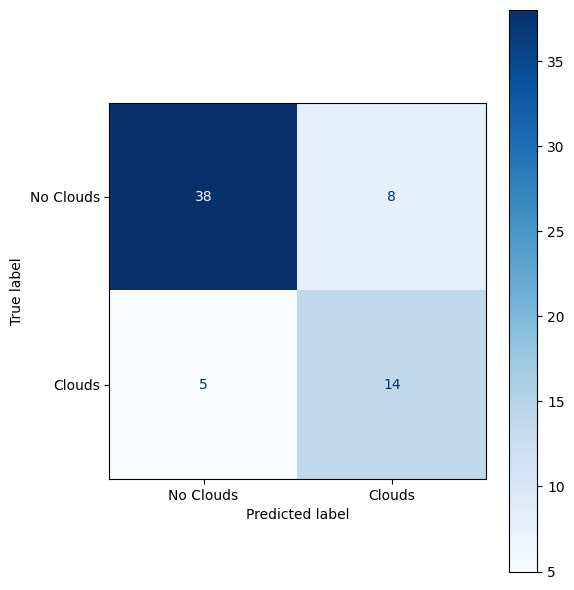

In [ ]:
# Initilisation and training
input_size = 22 * 22 * 3
num_classes = 2
num_epochs = 200

model = ANNClassifier(input_size, num_classes)
criterion = nn.CrossEntropyLoss(weight = class_weights)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs)
_, test_acc, all_labels, all_preds = test_model(test_loader, model)
print(f'Test Accuracy: {test_acc:.2f}%')
print("F1 score: {:.2f}%".format(f1_score(all_labels, all_preds) * 100))
plot_confusion_matrix(all_labels, all_preds, class_labels=['No Clouds', 'Clouds'])
